In [32]:
%matplotlib inline
import glymur
# from IPython.display import Image
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import numpy as np
import json, os
from glob import glob
from PIL import Image
from tqdm import tnrange, tqdm

In [218]:
config = json.load(open(os.path.expanduser("~/.thesis.conf")))
datasets_path = Path(config['datasets'])
db_folder = Path(config['datasets']) / 'hisdb'
modules   = Path(config['project']) / 'src'

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(modules))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
import skimage.io
import skimage.segmentation as seg
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import resize, rotate
from skimage import io
import matplotlib.pyplot as plt
import argparse
 
import random as rnd
import math
from collections import namedtuple

In [221]:
class Scale(object):
    def __init__(self, scale = 2**-2):
        self.scale = scale
        
    def __call__(self, image):
        return image.resize((int(image.width * self.scale), int(image.height * self.scale)))

In [277]:
class SLIC(object):
    
    def __init__(self, k=3000):
        self.k = k
    
    def __call__(self, image):
        floats = img_as_float(image)
        segments = seg.slic(floats, n_segments = self.k)
        return segments

In [305]:
class TileGroundTruth(object):
    def __init__(self, dtype=np.int):
        self.dtype = dtype
    
    def __call__(self, tile_meta, gt, scale):
        y = gt[np.round(tile_meta[:,0] / scale).astype(self.dtype), 
               np.round(tile_meta[:,1] / scale).astype(self.dtype)]
        return y

In [283]:
class SegmentTiling(object):
    def __init__(self, patch_width=28):
        self.patch_width = patch_width
    
    def __call__(self, image, segments):
        SLICPixel = namedtuple('SLICPixel', ['x', 'y', 'width', 'height'])
        Point = namedtuple('Point', ['x', 'y'])
        
        nsegments = np.max(segments)
        patches    = np.zeros((nsegments, self.patch_width, self.patch_width, 3),dtype=image.dtype)
        patch_meta = np.zeros((nsegments, 3), dtype=np.int32)
        patch_count = 0
        
        for snum in tqdm(range(0, nsegments)):
            spixel = np.where(segments == snum)
            mmin, nmin = list(map(min,spixel))
            mmax, nmax = list(map(max,spixel))

            spixel = SLICPixel(mmin, nmin, mmax - mmin, nmax - nmin) 
            center = Point(int(spixel.x + (spixel.width)/2) + 0.5, 
                           int(spixel.y + (spixel.height)/2 + 0.5))
            patch = SLICPixel(center.x - self.patch_width / 2, 
                              center.y - self.patch_width / 2, 
                              self.patch_width, self.patch_width)
            dimension  = mmax - mmin, nmax - nmin
            p = centered_patch(patch.x, patch.y, patch.width)
            img_patch = image[p]
            
            if img_patch.shape[0] == self.patch_width and img_patch.shape[1] == self.patch_width:
        #         print(patch)
                patches[patch_count, :, :] = img_patch
                patch_meta[patch_count, :] = [center.x, center.y, snum]
                patch_count += 1
        # prune
        patches = patches[:patch_count]
        patch_meta = patch_meta[:patch_count]
        return patches, patch_meta
    
    def centered_patch(m, n, width, offset=[0,0]):
        return (slice(int(m + offset[0]),
                     int(m + offset[0] + width)),
               slice(int(n + offset[1] ),
                     int(n + offset[1] + width)))

In [239]:
import datasets.divahisdb as diva
dataset = diva.HisDBDataset(datasets_path / diva.NAME, gt=True)
page, gt = dataset[0]

In [307]:
scaler = Scale()
slic = SLIC()
get_tiles = SegmentTiling()
get_gt = TileGroundTruth()

In [299]:
scaled = scaler(page)
spixel = slic(scaled)
tiles, tile_specs = get_tiles(img_as_ubyte(scaled), spixel)

100%|██████████| 2553/2553 [00:24<00:00, 105.83it/s]


In [308]:
y = get_gt(tile_specs, gt, scaler.scale)

In [315]:
np.sum(diva.to_class_vector(y), axis=0)

array([  87,   15,   55, 2275], dtype=uint64)

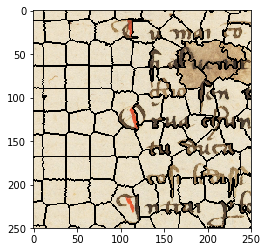

In [251]:
p = 300
box = (slice(p,p+250), slice(p,p+250))
fig = plt.figure()
plt.imshow(mark_boundaries(img_as_ubyte(scaled)[box], segments[box],color=(0,0,0)),cmap='flag')

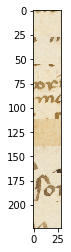

In [290]:
n = 1450
s = slice(n,n+8)
plt.imshow(np.concatenate(tiles[s]))
# print(patch_meta[s,2])
# print(y[s])
# diva.Annotations(y[s][1])
    

In [125]:

patchtes = patches[:patch_count]
patch_meta = patch_meta[:patch_count]

In [203]:
s + 8

TypeError: unsupported operand type(s) for +: 'slice' and 'int'

[1804 1805 1806 1807 1808 1809 1810 1811]
[1 1 1 1 1 1 1 1]


<Annotations.BACKGROUND: 1>

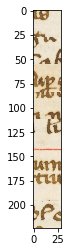

In [202]:
n = 1750
s = slice(n,n+8)
plt.imshow(np.concatenate(patches[s]))
print(patch_meta[s,2])
print(y[s])
diva.Annotations(y[s][1])

In [23]:
def img_offsets(directions=[0], width=28, jitter=7):
    """
    calculates offsets in the specified directions.
    Spacing is specified by width.
    Adds jitter
    """
    offsets = np.zeros((len(directions), 2))
    for idx, direction in enumerate(directions):
        print(direction)
        offset[idx] = [width * direction[0]  + rnd.randint(-jitter,jitter),
                       width * direction[1]  + rnd.randint(-jitter,jitter)]
    return offsets

In [185]:
y = gt[np.round(patch_meta[:,0] / scale).astype(int), np.round(patch_meta[:,1] / scale).astype(int)]

In [206]:
out = np.ones((image.shape[0], image.shape[1], 1), dtype=gt.dtype)
for x,y, snum in patch_meta[:10]:
    spixel = np.where(segments == snum)

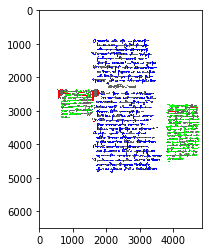

In [207]:
plt.imshow(diva.color_gt(gt))